In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [2]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')

train_targets_a = pd.read_parquet('../data/A/train_targets.parquet')
train_targets_b = pd.read_parquet('../data/B/train_targets.parquet')
train_targets_c = pd.read_parquet('../data/C/train_targets.parquet')

In [3]:
X_train = pd.concat([X_train_observed_a, X_train_estimated_a])
agg_func = {col: 'mean' for col in X_train.columns[1:]}

X_train_downscaled = X_train.groupby(X_train.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

train_targets_a.head()
train_targets_a.tail()


,time,pv_measurement
34080,2023-04-30 19:00:00,9.02
34081,2023-04-30 20:00:00,0.00
34082,2023-04-30 21:00:00,0.00
34083,2023-04-30 22:00:00,0.00
34084,2023-04-30 23:00:00,0.00


In [26]:

#print(X_train_estimated_a.head())
ts = pd.DataFrame()
ts["ds"] = pd.to_datetime(train_targets_a['time'])
ts["y"] = train_targets_a['pv_measurement']
ts['cap'] = 6000
ts['floor'] = 0
print(ts.head())

#X_train['ds'] = X_train['timestamp'] ## Kom tilbake til hit.
#X_train['y'] = train_targets_a['pv_measurement']
#print(X_train['ds'].head())
#print(X_train.shape)
#print(train_targets_a.head())
m = Prophet(growth="logistic", yearly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.01)

m.fit(ts)
future = m.make_future_dataframe(periods=30, freq='D')
future.tail()
future['floor'] = 0
future['cap'] = 6000
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

                   ds      y   cap  floor
0 2019-06-02 22:00:00   0.00  6000      0
1 2019-06-02 23:00:00   0.00  6000      0
2 2019-06-03 00:00:00   0.00  6000      0
3 2019-06-03 01:00:00   0.00  6000      0
4 2019-06-03 02:00:00  19.36  6000      0


09:37:53 - cmdstanpy - INFO - Chain [1] start processing
09:37:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
34110,2023-05-26 23:00:00,716.213269,-235.645120,1720.780580
34111,2023-05-27 23:00:00,717.454941,-309.802755,1725.601443
34112,2023-05-28 23:00:00,764.695038,-228.773534,1736.486625
34113,2023-05-29 23:00:00,780.169539,-298.620599,1800.895408
34114,2023-05-30 23:00:00,803.383345,-209.518498,1850.782240


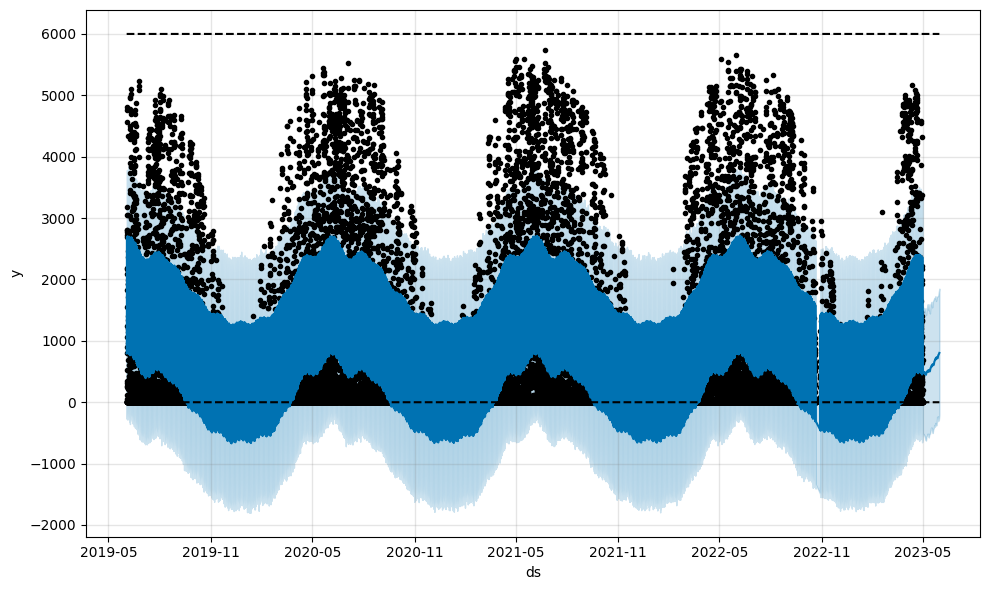

In [27]:
fig1 = m.plot(forecast)
#fig2 = m.plot_components(forecast)

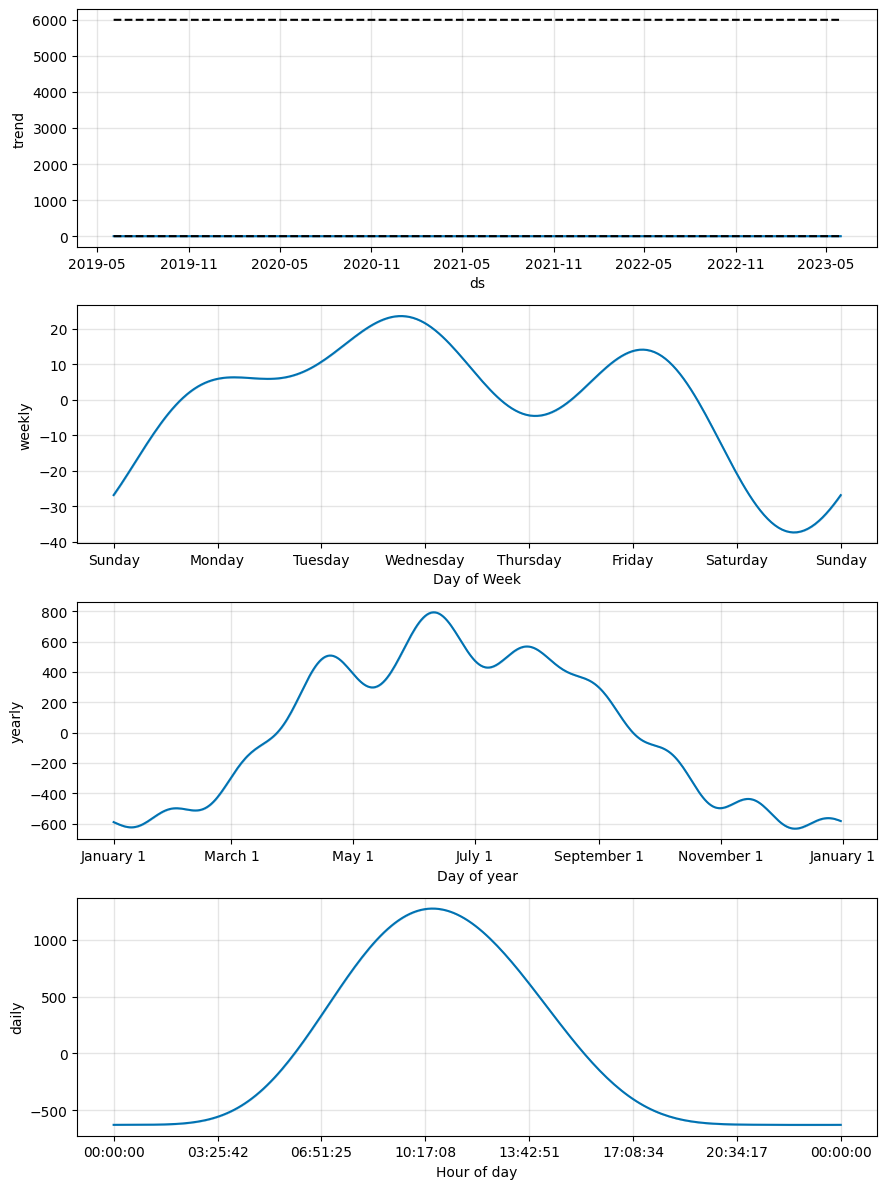

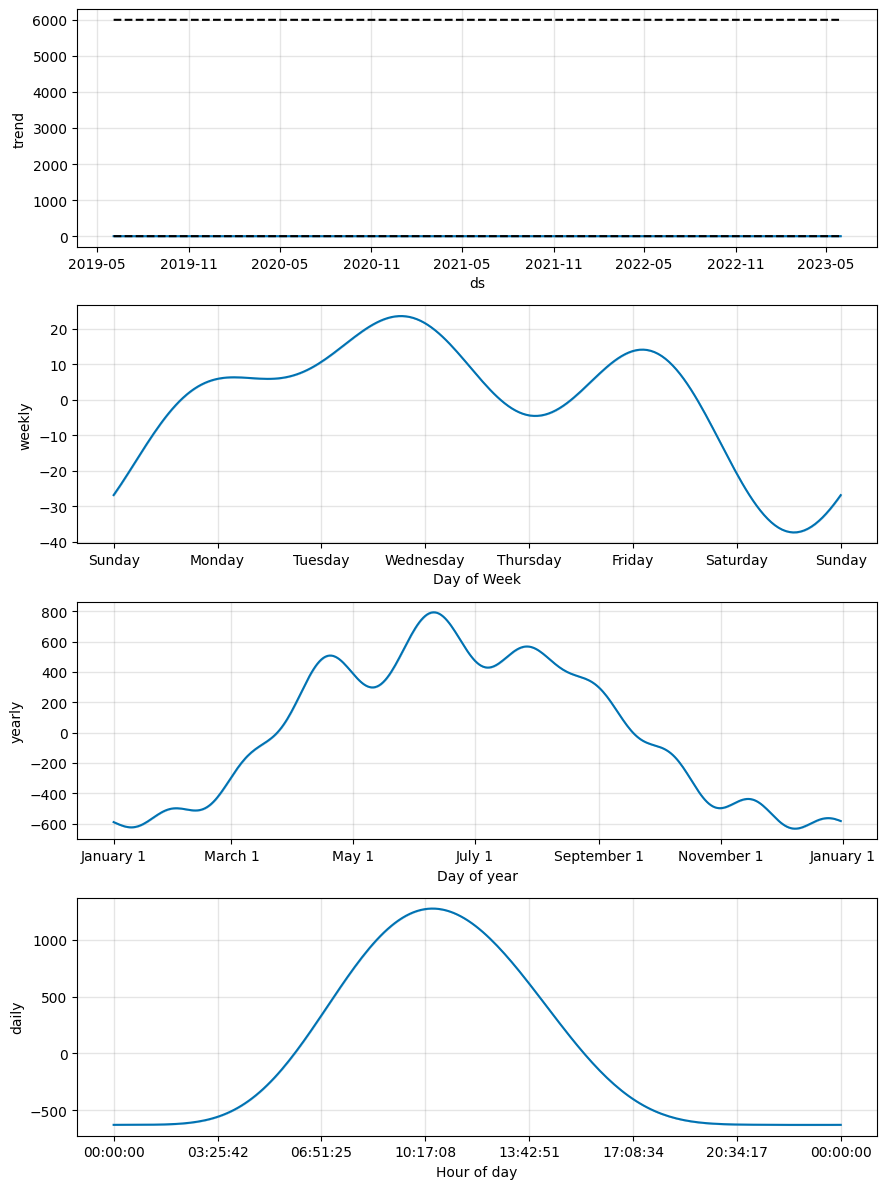

In [7]:
m.plot_components(forecast)

In [14]:
forecast[['ds', 'yhat']].tail()


,ds,yhat
34110,2023-05-26 23:00:00,716.674817
34111,2023-05-27 23:00:00,717.844856
34112,2023-05-28 23:00:00,765.008905
34113,2023-05-29 23:00:00,780.420292
34114,2023-05-30 23:00:00,803.563622


In [6]:
# y_test_pred = ...


test = pd.read_csv('../data/test.csv')
test['prediction'] = forecast['yhat'].values[-30:]
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'